# Natural Language Processing with Disaster Tweets

With the ever increasing role of Twitter in modern communications, multiple organizations are interested in programatically monitoring Twitter to detect occurring emergencies. However, it is not always clear whether a message containing "alarming" words is about a real emergency or is only a figure of speech. The goal of this project is to create a Regression Network model capable of predicting which Tweets are about real disasters and which one’s aren’t. 

For any given image, a positive label '1' indicates that the Tweet is about a real disaster, with a negative label '0' otherwise. The dataset consists of 10,000 tweets that were hand classified by the company "Figure-Eight".

## Setup

In [41]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers



### Exploratory Data Analysis

First, we begin by observing a few sample rows and then obtaining the dataset's main statistics.

In [42]:
# Read dataset and create training an testing datasets
# id     keyword    location    text    target
training_csv_data = pd.read_csv('./Data/train.csv')
testing_csv_data = pd.read_csv('./Data/test.csv')

print(training_csv_data.head())
training_csv_data.describe()

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


We can see that beside the "id", "text" and "target" columns we also have the additional "keyword" and "location" columns. Likewise, based on the "target" mean we can see that the True and False groups are roughly equally distributed.

Below we can better visualize the training dataset distribution with a histogram.

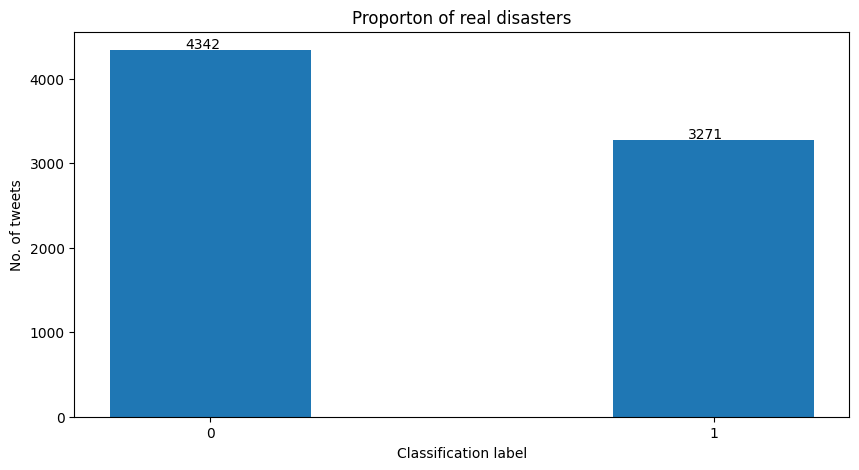

In [43]:
# creating the dataset
data = training_csv_data["target"].value_counts()
topics = list(data.axes[0])
topics = [str(item) for item in topics]
values = list(data.values)
  
fig = plt.figure(figsize = (10, 5))
plt.bar(topics, values, width = 0.4)

for i in range(len(values)):
        plt.text( i-0.05, values[i]+20, values[i])

plt.xlabel("Classification label")
plt.ylabel("No. of tweets")
plt.title("Proporton of real disasters")
plt.show()

As seen above, there are 4,342 tweets of fake disasters and 3,271 of real disasters. This skew is not so large as to require a dataset re-balancing during model creation and training. Furthermore, the large amount of samples within each group will compensate for the imperfect split.

### Dataset Construction

First, to be able to properly inport all samples as a Keras dataset, each text in the training dataset will be exported as a ".txt" file, seperated according to their label.

In [4]:
training_directory = "./Data/train/"

# For all files in training directory
for ind in training_csv_data.index:
    # Create filename using label and ID
    filename = training_directory + str(training_csv_data["target"][ind]) + "/" + str(training_csv_data["id"][ind]) + ".txt"
    
    # Export the sample's text
    text_file = open(filename, "w")
    text_file.write(training_csv_data["text"][ind])
    text_file.close()

Likewise, all testing samples will be exported to ".txt" files, albeit without creating any classes.

In [5]:
testing_directory = "./Data/test/"

# For all files in testing directory
for ind in testing_csv_data.index:
    # Create filename using ID
    filename = testing_directory + str(testing_csv_data["id"][ind]) + ".txt"
    
    # Export the sample's text
    text_file = open(filename, "w")
    text_file.write(testing_csv_data["text"][ind])
    text_file.close()

Then, we import the training samples using the text_dataset_from_directory() function and create a validation split with 15% of the samples.

In [44]:
training_dataset, validation_dataset = tf.keras.utils.text_dataset_from_directory(
    "./Data/train/",
    label_mode="binary",
    validation_split=0.15,
    shuffle=True,
    batch_size=None,
    subset="both",
    seed=1337,
)

Found 7613 files belonging to 2 classes.
Using 6472 files for training.
Using 1141 files for validation.


Likewise, we also import the testing dataset, disabling shuffling and dataset splitting.

In [45]:
testing_dataset = tf.keras.utils.text_dataset_from_directory(
    "./Data/test/",
    labels=None,
    label_mode=None,
    batch_size=None,
    shuffle=False
)

Found 3263 files belonging to 1 classes.


To be able to properly link predictions to sample IDs, we create an array of IDs using the os.walk() function, which will obtain the filenames of all testing samples in the same order as the text_dataset_from_directory() function.

In [46]:
for root, dirs, files in os.walk("./Data/test/", topdown=False):
    testing_ids = [name[:len(name)-4] for name in files]
print(len(testing_ids))

3263


To properly use the datasets during vectorization, we split them into 32-item batches. Once again, only training and validation datasets are shuffled.

In [47]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

training_dataset_ = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset_ = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
testing_dataset_ = testing_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Architecture

### Model Selection

We create an encoding layer using TextVectorization() that has been adapted with the training dataset texts.

In [20]:
encoder = layers.TextVectorization(max_tokens=1000)
encoder.adapt(training_dataset_.map(lambda text, label: text))

Then, we create a sequential model to encode the inputs, pass them through a bidirectional LSTM model and then use a Dense layer to obtain the final output.

In [55]:
# Define model's architecture
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(1)),
    layers.Dense(1, activation="sigmoid")
])

# Print model's architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         300000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 2)                2416      
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 3         
                                                                 
Total params: 302,419
Trainable params: 302,419
Non-trainable params: 0
_________________________________________________________________


#### Model Training

For training the model a maximum of 20 epochs will be used, with an early stopping optimizer with a patience of 3 epochs.

The model's loss will be calculated using Binary Cross-Entropy. The metrics for Accuracy, Precision and Recall will also be calculated to evaluate the learning rate after training is complete

In [56]:
# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss="binary_crossentropy",
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
) 


Epoch 1/20


203/203 [==============================] - 12s 29ms/step - loss: 0.6782 - binary_accuracy: 0.5981 - precision: 0.7986 - recall: 0.0843 - val_loss: 0.6624 - val_binary_accuracy: 0.6047 - val_precision: 0.9400 - val_recall: 0.0949
Epoch 2/20
203/203 [==============================] - 4s 21ms/step - loss: 0.6243 - binary_accuracy: 0.7194 - precision: 0.8791 - recall: 0.4009 - val_loss: 0.5989 - val_binary_accuracy: 0.7415 - val_precision: 0.8165 - val_recall: 0.5212
Epoch 3/20
203/203 [==============================] - 5s 22ms/step - loss: 0.5530 - binary_accuracy: 0.7838 - precision: 0.8225 - recall: 0.6326 - val_loss: 0.5547 - val_binary_accuracy: 0.7572 - val_precision: 0.8449 - val_recall: 0.5394
Epoch 4/20
203/203 [==============================] - 4s 21ms/step - loss: 0.5063 - binary_accuracy: 0.8061 - precision: 0.8302 - recall: 0.6888 - val_loss: 0.5319 - val_binary_accuracy: 0.7642 - val_precision: 0.7384 - val_recall: 0.7071
Epoch 5/20
203/203 [==============================] - 

#### Model Results

To evaluate the model's training efficiency we can plot the evaluation metrics across time for each epoch.

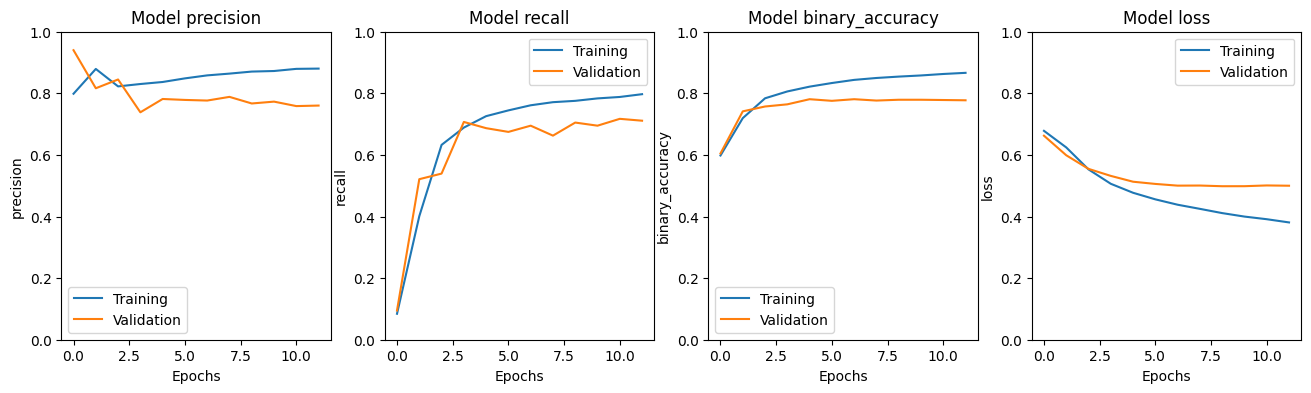

In [57]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


We can observe that the model obtained a training accuracy of 0.86 while the validation had an accuracy of 0.77, which had plateaued around the fifth iteration.

Finally, we can make a prediction onto the testing dataset and export it into a CSV file for submittion onto Kaggle. 

In [54]:
# Obtain predicted labels for testing dataset. Round predictions to obtain 0/1 values.
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

# Merge testing IDs and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

# Export predictions to a CSV file
testing_results.to_csv("./Data/results1.csv", index=False)
testing_results.head()

  1/102 [..............................] - ETA: 2s

102/102 [==============================] - 1s 7ms/step


,id,target
0,0,1
1,1000,0
2,10002,0
3,10007,1
4,10015,0


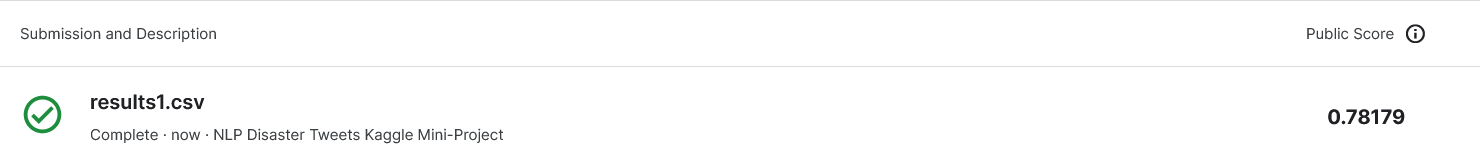

We can see that this initial architecture had good results, with an 78% score on the Testing Dataset. We can now try and improve this score by training models with different parameters.

## Alternative Models

### First Alternative

Firstly, we will observe the results of adding a second Dense layer to better process the output of the first LSTM layer. For this, the output of the first LSTM model will be increased to 100 and the new Dense layer will have 30 outputs.

In [59]:
# Define model's architecture
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dense(30, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Print model's architecture
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, None, 300)         300000    
                                                                 
 bidirectional_11 (Bidirecti  (None, 200)              320800    
 onal)                                                           
                                                                 
 dense_17 (Dense)            (None, 30)                6030      
                                                                 
 dense_18 (Dense)            (None, 1)                 31        
                                                                 
Total params: 626,861
Trainable params: 626,861
Non-t

In [60]:
# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss="binary_crossentropy",
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
) 


Epoch 1/20
203/203 [==============================] - 14s 35ms/step - loss: 0.5843 - binary_accuracy: 0.7013 - precision: 0.7782 - recall: 0.4247 - val_loss: 0.5087 - val_binary_accuracy: 0.7677 - val_precision: 0.7522 - val_recall: 0.6929
Epoch 2/20
203/203 [==============================] - 4s 19ms/step - loss: 0.4341 - binary_accuracy: 0.8112 - precision: 0.8381 - recall: 0.6938 - val_loss: 0.4934 - val_binary_accuracy: 0.7835 - val_precision: 0.8605 - val_recall: 0.5980
Epoch 3/20
203/203 [==============================] - 5s 22ms/step - loss: 0.3966 - binary_accuracy: 0.8266 - precision: 0.8507 - recall: 0.7226 - val_loss: 0.4912 - val_binary_accuracy: 0.7905 - val_precision: 0.8092 - val_recall: 0.6768
Epoch 4/20
203/203 [==============================] - 5s 23ms/step - loss: 0.3752 - binary_accuracy: 0.8422 - precision: 0.8637 - recall: 0.7507 - val_loss: 0.4821 - val_binary_accuracy: 0.7844 - val_precision: 0.8184 - val_recall: 0.6465
Epoch 5/20
203/203 [=======================

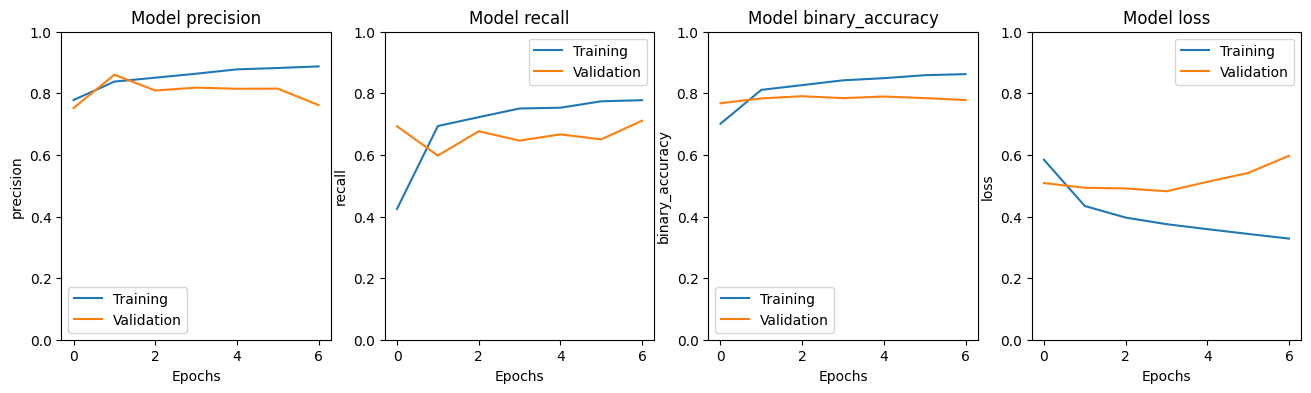

In [61]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


This model obtained a very similar output to the previous one, but it required less training iterations.

In [62]:
# Obtain predicted labels for testing dataset. Round predictions to obtain 0/1 values.
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

# Merge testing IDs and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

# Export predictions to a CSV file
testing_results.to_csv("./Data/results2.csv", index=False)
testing_results.head()

102/102 [==============================] - 3s 9ms/step


,id,target
0,0,1
1,1000,0
2,10002,0
3,10007,1
4,10015,0


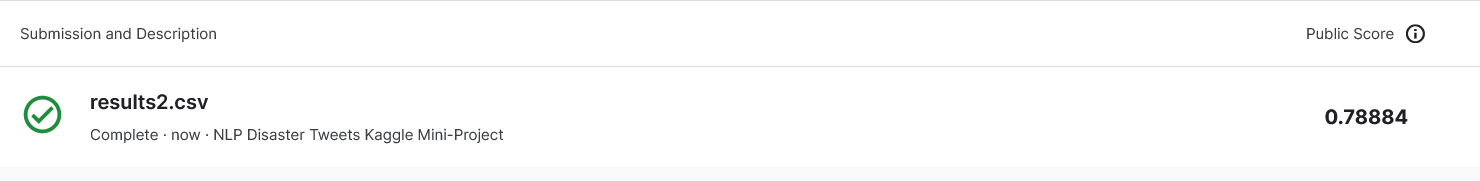

While this model did improve the obtained score, it was a very small increment and it also required doubling the training parameters (from 302,419 to 626,861)

### Second Alternative Model

For comparison, we will also evaluate the result obtained when the LSTM model is not wrapped in a Bidirectional layer.

In [67]:
# Define model's architecture
model = tf.keras.Sequential([
    encoder,
    layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=300,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.LSTM(1),
    layers.Dense(1, activation="sigmoid")
])

# Print model's architecture
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_12 (Embedding)    (None, None, 300)         300000    
                                                                 
 lstm_13 (LSTM)              (None, 1)                 1208      
                                                                 
 dense_19 (Dense)            (None, 1)                 2         
                                                                 
Total params: 301,210
Trainable params: 301,210
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Define early stop callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Add optimizers and evaluation metrics to model
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    # optimizer=keras.optimizers.SGD(learning_rate=0.00125),
    loss="binary_crossentropy",
    # loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
             keras.metrics.BinaryAccuracy(),
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")
             ],
)

# Train model
history = model.fit(
    training_dataset_,
    epochs=20,
    validation_data=validation_dataset_,
    callbacks=[early_stopping_cb]
) 


Epoch 1/20


203/203 [==============================] - 7s 18ms/step - loss: 0.6768 - binary_accuracy: 0.5896 - precision: 0.7419 - recall: 0.0663 - val_loss: 0.6601 - val_binary_accuracy: 0.6004 - val_precision: 0.8679 - val_recall: 0.0929
Epoch 2/20
203/203 [==============================] - 3s 14ms/step - loss: 0.6179 - binary_accuracy: 0.7033 - precision: 0.8323 - recall: 0.3862 - val_loss: 0.5949 - val_binary_accuracy: 0.7257 - val_precision: 0.8160 - val_recall: 0.4747
Epoch 3/20
203/203 [==============================] - 3s 13ms/step - loss: 0.5427 - binary_accuracy: 0.7693 - precision: 0.7980 - recall: 0.6189 - val_loss: 0.5489 - val_binary_accuracy: 0.7441 - val_precision: 0.7781 - val_recall: 0.5737
Epoch 4/20
203/203 [==============================] - 3s 14ms/step - loss: 0.4952 - binary_accuracy: 0.7896 - precision: 0.8021 - recall: 0.6762 - val_loss: 0.5230 - val_binary_accuracy: 0.7564 - val_precision: 0.7577 - val_recall: 0.6444
Epoch 5/20
203/203 [==============================] - 3

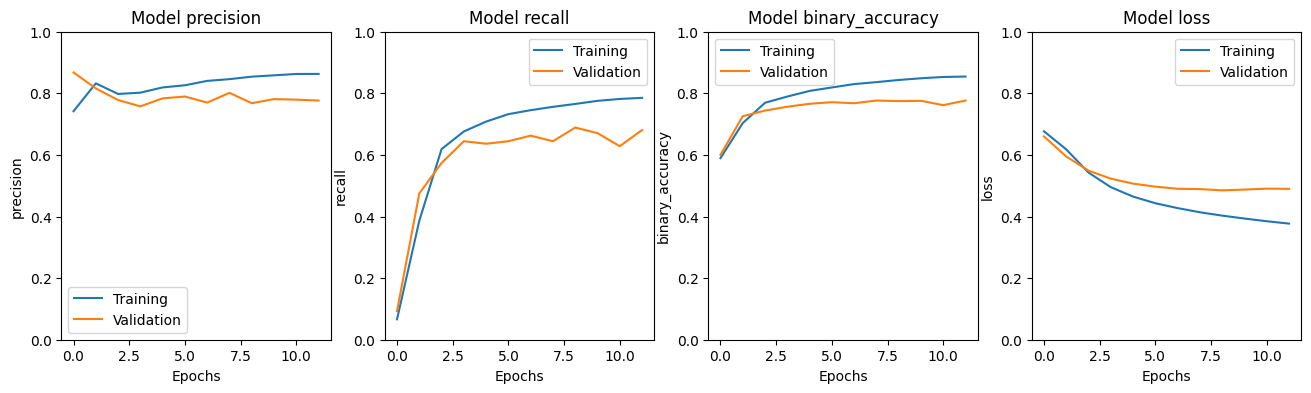

In [69]:
graph_metrics = ["precision", "recall", "binary_accuracy", "loss"]
# graph_metrics = ["binary_accuracy", "loss"]

fig, ax = plt.subplots(1, len(graph_metrics), figsize=(16, 4))
ax = ax.ravel()

for i, metric in enumerate(graph_metrics):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model " + metric)
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Training", "Validation"])
    ax[i].set_ylim(ymin=0, ymax=1)


Once again the result is very similar to the previous models, with only a minute dicrease in trainable parameters.

In [70]:
# Obtain predicted labels for testing dataset. Round predictions to obtain 0/1 values.
testing_predictions = model.predict(testing_dataset_)
testing_prediction_labels = [round(item[0]) for item in testing_predictions.tolist()]

# Merge testing IDs and predictions and export as a CSV file.
testing_results = pd.DataFrame({"id": testing_ids, "target": testing_prediction_labels})
testing_results = testing_results.sort_values(by=['id'], ascending=True)

# Export predictions to a CSV file
testing_results.to_csv("./Data/results3.csv", index=False)
testing_results.head()

102/102 [==============================] - 1s 5ms/step


,id,target
0,0,1
1,1000,0
2,10002,0
3,10007,1
4,10015,0


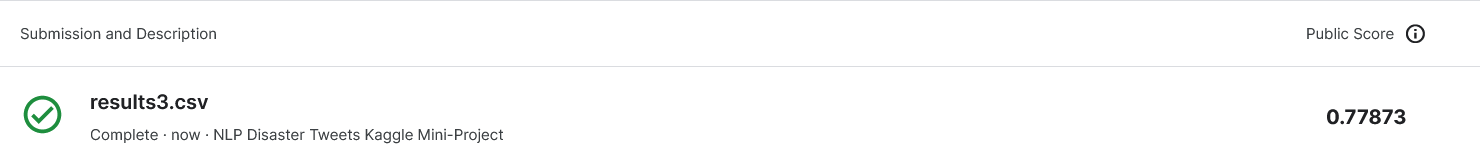

This final model obtained a very close score to the previous models (77.9%). However, the first model would still be abetter option, as it haad better results with the same training iterations and only a minimal increase in trainable parameters.

## Conclusions

The goal of classifying tweets with a RNN model was successfull, achieving a model with at least an Area Under the ROC Curve score of 0.782.

When comparing the multiple models we can conclude that, in a Regression Neural Network, changes to the global architecture such as adding Dense Layers do not have as much impact as the Regression layer itself. 

### Future works

If there was more time to fine-tune the model, it would be worth examining the implementation of custom LSTM configurations. It would also be worth explore the use of different Regression units, such as GRUs.

## References

* [Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle.](https://kaggle.com/competitions/nlp-getting-started)
* [Keras. LSTM layer](https://keras.io/api/layers/recurrent_layers/lstm/)
* [Keras. Bidirectional layer](https://keras.io/api/layers/recurrent_layers/bidirectional/)